# Grid Constraints

The limiting factor for the size of problem that can be solved with the brute-force grid approach used here is typically the memory available to store the large likelihood and posterior arrays within the `ExperimentDesigner` class.

In some problems, the full grid over some subset of variables (parameters, features or designs) is either redundant (e.g. because of some symmetry) or else the allowed combinations are limited by some constraint (e.g. `x**2 + y**2 < r**2`).

A common situation where is applies is when the likelihood $P(D \mid \theta, d)$ is invariant under permutations of some variables contained within the data features $D$, the parameters $\theta$ or the designs $d$. For example, if $x_1$ and $x_2$ are indistinguishable then we can require that $x_1 \le x_2$, without any loss of generality, and thereby reduce the size of the $(x_1,x_2)$ grid by roughly a factor of 2, and correspondingly reduce the size of the likelihood and posterior arrays by the same factor.

To demonstrate how grid constraints are implemented in the `bayesdesign` package, we revisit the [sine wave problem](https://observablehq.com/@dkirkby/boed) but now consider an experiment to consist of a pair of measurements $y_1, y_2$ made at times $t_1, t_2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from bed.grid import Grid, GridStack
from bed.design import ExperimentDesigner

## Reference Solution

We first solve this problem without any grid constraints, as a straightforward generalization of the single-measurement example.

In [3]:
designs = Grid(t1=np.linspace(0, 5, 35), t2=np.linspace(0, 5, 35))

In [4]:
features = Grid(y1=np.linspace(-1.25, 1.25, 50), y2=np.linspace(-1.25, 1.25, 50))

In [5]:
params = Grid(amplitude=1, frequency=np.linspace(0.2, 2.0, 181), offset=0)

In [6]:
sigma_y=0.1
with GridStack(features, designs, params):
    y1_mean = params.amplitude * np.sin(params.frequency * (designs.t1 - params.offset))
    y1_diff = features.y1 - y1_mean
    y2_mean = params.amplitude * np.sin(params.frequency * (designs.t2 - params.offset))
    y2_diff = features.y2 - y2_mean
    likelihood = np.exp(-0.5 * (y1_diff / sigma_y) ** 2) * np.exp(-0.5 * (y2_diff / sigma_y) ** 2)
    features.normalize(likelihood)

In [7]:
designer = ExperimentDesigner(params, features, designs, likelihood)

In [8]:
prior = np.ones(params.shape)
params.normalize(prior);

In [9]:
designer.calculateEIG(prior)
designer.describe()

GRID       designs [35:t1, 35:t2]
GRID      features [50:y1, 50:y2]
GRID    parameters [1:amplitude, 181:frequency, 1:offset]
ARRAY        prior (1, 181, 1)                0.0 Mb
ARRAY   likelihood (50, 50, 35, 35, 1, 181, 1)  4229.1 Mb
ARRAY    posterior (50, 50, 35, 35, 1, 181, 1)  4229.1 Mb
ARRAY     marginal (50, 50, 35, 35)          23.4 Mb
ARRAY           IG (50, 50, 35, 35)          23.4 Mb
ARRAY          EIG (35, 35)                   0.0 Mb


Note that the likelihood and posterior arrays are each about 4.2 Gb in size.

In [10]:
i1, i2 = np.unravel_index(np.argmax(designer.EIG), designer.EIG.shape)
t1, t2 = designer.designs.t1[i1,0], designer.designs.t2[i2]
print(f'Maximum EIG of {designer.EIG[i1,i2]:.2f} at t1={t1:.2f}, t2={t2:.2f}')

Maximum EIG of 4.06 at t1=3.82, t2=5.00


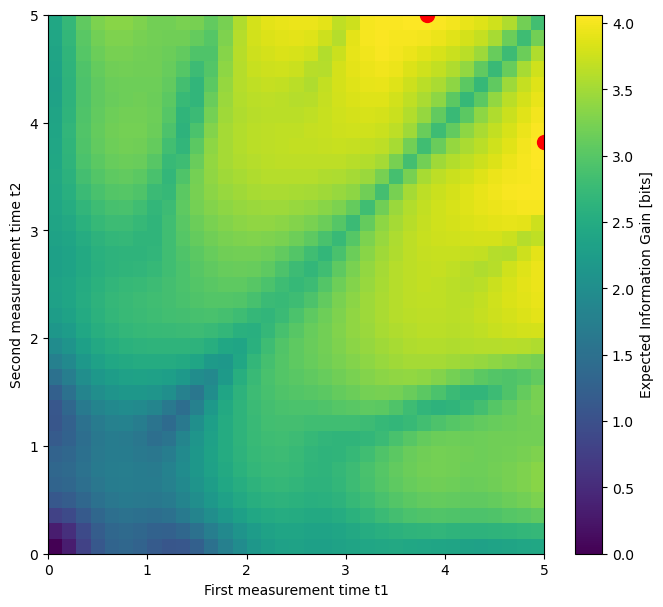

In [11]:
fig, ax = plt.subplots(figsize=(8,7))
I = ax.imshow(designer.EIG, origin='lower', extent=designs.extent('t1')+designs.extent('t2'), aspect='auto')
plt.colorbar(I, ax=ax, label='Expected Information Gain [bits]')
ax.plot([t1,t2], [t2,t1], 'ro', markersize=10)
ax.set(xlabel='First measurement time t1', ylabel='Second measurement time t2');

A plot of the EIG versus the two measurement times shows that:
 - EIG is symmetric under the exchange of $t_1$ and $t_2$, as expected.
 - EIG is generally lower along the diagonal, since repeating a measurement at the same time is not optimal.
 - The maximum EIG of about 4 bits occurs for $t_1 = 3.82$ and $t_2 = 5.00$ (or with these swapped).

Compare a plot of the diagonal of this 2D EIG plot with the EIG for a single measurement from the SineWave notebook. They have essentially the same shape but information values are higher along the diagonal by about 0.4 bits since repeating a measurement at the same time does still provide some information due to the error of the measurement process (set by $\sigma_y = 0.1$ in this example).

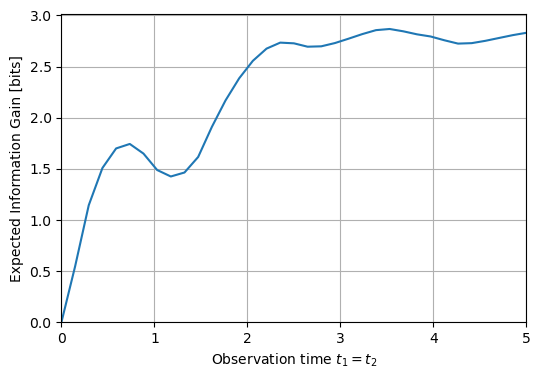

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs.t1, np.diag(designer.EIG))
ax.set(xlabel='Observation time $t_1=t_2$', xlim=designs.extent('t1'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.grid();

## Solution with Constrained Design Space

Next, impose permutation symmetry on the design space by requiring that $t_1 \le t_2$. We only need to redefine the features grid to accomplish this:

In [13]:
designs2 = Grid(t1=np.linspace(0, 5, 35), t2=np.linspace(0, 5, 35), keep__t1__t2=lambda t1,t2: t1<=t2)

If we compare the shapes of the full and constrained features grid, we see that it is about a factor of 2 smaller:

In [14]:
designs.shape, designs2.shape

((35, 35), (630, 1))

We can use exactly the same code to calculate the likelihood, but just replacing `designs` with `designs2`:

In [15]:
sigma_y=0.1
with GridStack(features, designs2, params):
    y1_mean = params.amplitude * np.sin(params.frequency * (designs2.t1 - params.offset))
    y1_diff = features.y1 - y1_mean
    y2_mean = params.amplitude * np.sin(params.frequency * (designs2.t2 - params.offset))
    y2_diff = features.y2 - y2_mean
    likelihood2 = np.exp(-0.5 * (y1_diff / sigma_y) ** 2) * np.exp(-0.5 * (y2_diff / sigma_y) ** 2)
    features.normalize(likelihood2)

Run the EIG calculation with this constrained grid:

In [16]:
designer2 = ExperimentDesigner(params, features, designs2, likelihood2)

In [17]:
designer2.calculateEIG(prior)
designer2.describe()

GRID       designs [630:t1, 630:t2]
GRID      features [50:y1, 50:y2]
GRID    parameters [1:amplitude, 181:frequency, 1:offset]
ARRAY        prior (1, 181, 1)                0.0 Mb
ARRAY   likelihood (50, 50, 630, 1, 1, 181, 1)  2174.9 Mb
ARRAY    posterior (50, 50, 630, 1, 1, 181, 1)  2174.9 Mb
ARRAY     marginal (50, 50, 630, 1)          12.0 Mb
ARRAY           IG (50, 50, 630, 1)          12.0 Mb
ARRAY          EIG (630, 1)                   0.0 Mb


Expand this constrained EIG to the full shape of the unconstrained EIG for comparison:

In [18]:
EIG2 = np.full(designer.EIG.shape, np.nan)
i, j = np.triu_indices(designer.EIG.shape[0], 0)
EIG2[j,i] = designer2.EIG.ravel()

Plot the expanded EIG and verify that it matches the plot above in the upper-triangular region where $t_1 \le t_2$:

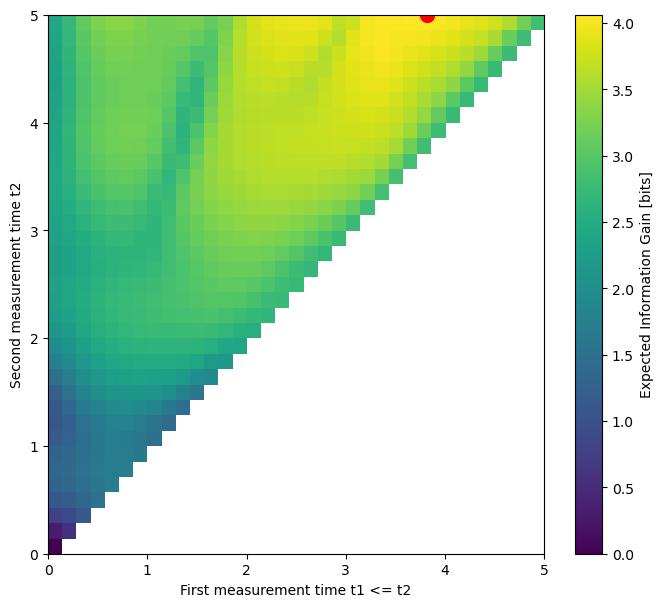

In [19]:
fig, ax = plt.subplots(figsize=(8,7))
I = ax.imshow(EIG2, origin='lower', extent=designs.extent('t1')+designs.extent('t2'), aspect='auto')
plt.colorbar(I, ax=ax, label='Expected Information Gain [bits]')
ax.plot(t1, t2, 'ro', markersize=10)
ax.set(xlabel='First measurement time t1 <= t2', ylabel='Second measurement time t2');